图像
----------

torchvision包：
- 支持加载类似Imagenet CIFAR10 MNIST等公共数据集的数据加载模块torchvision.datasets
- 支持加载图像数据转换模块 torch.utils.data.Dataloader

这里使用CIFAR10数据集，包含十个类别。
尺寸是3 * 32 * 32

#### 训练一个图像分类器：
- 使用torchvision加载并归一化C10的训练集和测试集
- 定义一个卷积神经网络
- 定义一个损失函数
- 在训练set上训练网络
- 在测试set上测试网络

加载并归一化C10
---------------

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvisio的数据集输出范围是[0, 1]之间的PILImage,我们将其归一为[-1, 1]之间的张量Tensors

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'cat', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
!pip3 install matplotlib

     |████████████████████████████████| 11.6 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 5.8 MB/s eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)


In [19]:
%matplotlib inline

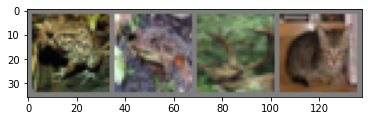

 frog  frog  deer   cat


In [23]:
# 展示一些训练集中的图片
import matplotlib.pyplot as plt
import numpy as np

# show image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

定义神经网络
------------------

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


定义损失函数和优化器
---------------------
- 损失函数： 交叉熵cross-entropy
- 优化器：动量SGD

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

训练网络
------------------
只需要在数据迭代器上循环传给网络和优化器输入就可以了。

In [27]:
for epoch in range(2): # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimizer
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i%2000 == 1999:
            # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 2.235
[1,  4000] loss: 1.902
[1,  6000] loss: 1.677
[1,  8000] loss: 1.572
[1, 10000] loss: 1.505
[1, 12000] loss: 1.453
[2,  2000] loss: 1.395
[2,  4000] loss: 1.368
[2,  6000] loss: 1.345
[2,  8000] loss: 1.320
[2, 10000] loss: 1.309
[2, 12000] loss: 1.280
Finished Training


测试网络
------------- 

我们已经在训练集上训练了两边网络
现在需要检查以下是否真的学到了东西

首先从测试集里挑出图片来

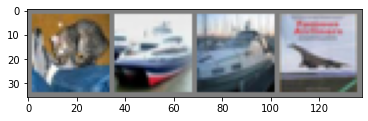

GroundTruth:    cat  ship  ship plane


In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
# 接下来看看 nn认为这些例子是什么

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

predicted:   bird  ship  ship plane


In [31]:
# 看网络在整个测试集上的表现

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on 1w test images: %d %%' % (100 * correct / total))


Accuracy of the network on 1w test images: 55 %


In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   cat : 63 %
Accuracy of  bird : 48 %
Accuracy of   cat : 33 %
Accuracy of  deer : 26 %
Accuracy of   dog : 56 %
Accuracy of  frog : 69 %
Accuracy of horse : 56 %
Accuracy of  ship : 69 %
Accuracy of truck : 66 %


Training on GPU
------------------------

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0
